In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from category_encoders import TargetEncoder
pd.set_option('display.max_columns', None)

In [2]:
income = pd.read_csv('./data/large_train_sample.csv')

In [3]:
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [4]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  wage            32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

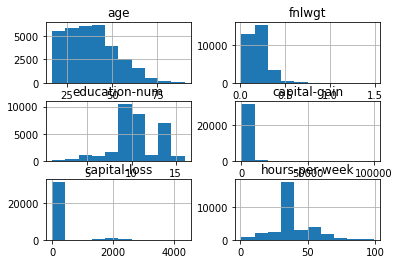

In [5]:
income._get_numeric_data().hist()

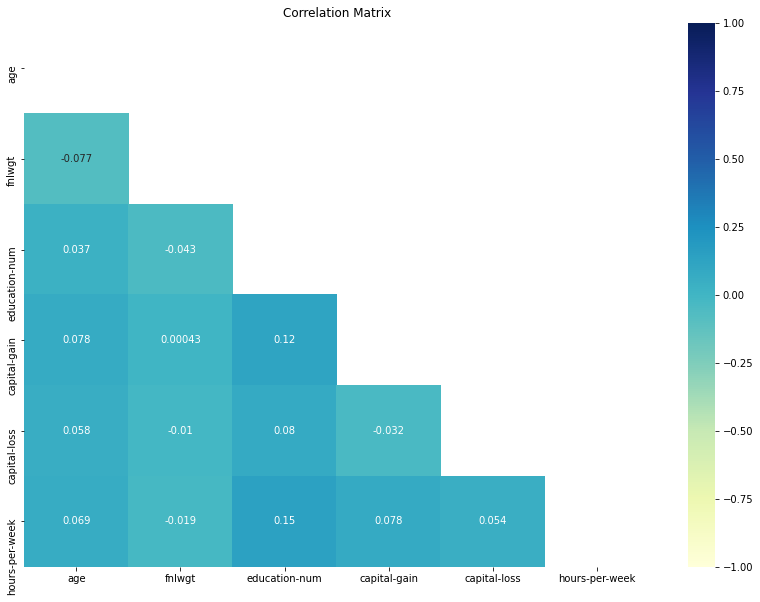

In [6]:
#Let's find the correlations between all fields
corr = income.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14,10))
plt.title('Correlation Matrix')
sns.heatmap(corr, cmap='YlGnBu', annot=True, vmin=-1, vmax=1, mask=mask,);

In [7]:
income.value_counts(ascending = False)

age  workclass          fnlwgt  education      education-num  marital-status       occupation        relationship    sex      capital-gain  capital-loss  hours-per-week  native-country  wage  
25    Private           195994   1st-4th       2               Never-married        Priv-house-serv   Not-in-family   Female  0             0             40               Guatemala       <=50K    3
19    Private           97261    HS-grad       9               Never-married        Farming-fishing   Not-in-family   Male    0             0             40               United-States   <=50K    2
42    Private           204235   Some-college  10              Married-civ-spouse   Prof-specialty    Husband         Male    0             0             40               United-States   >50K     2
49    Self-emp-not-inc  43479    Some-college  10              Married-civ-spouse   Craft-repair      Husband         Male    0             0             40               United-States   <=50K    2
19    Private  

In [8]:
income.replace(' ?', "unknown", inplace = True )

In [9]:
# Makes a copy of the original dataframe to test whether dropping unknowns altogether is better than renaming them
income_dropna = income.copy()
income_dropna.replace(' ?', np.nan, inplace=True)
income_dropna.dropna(inplace=True)

In [10]:
income.value_counts(ascending = False)

age  workclass     fnlwgt  education      education-num  marital-status       occupation         relationship    sex      capital-gain  capital-loss  hours-per-week  native-country  wage  
25    Private      195994   1st-4th       2               Never-married        Priv-house-serv    Not-in-family   Female  0             0             40               Guatemala       <=50K    3
                   308144   Bachelors     13              Never-married        Craft-repair       Not-in-family   Male    0             0             40               Mexico          <=50K    2
35    Private      379959   HS-grad       9               Divorced             Other-service      Not-in-family   Female  0             0             40               United-States   <=50K    2
39    Private      30916    HS-grad       9               Married-civ-spouse   Craft-repair       Husband         Male    0             0             40               United-States   <=50K    2
90    Private      52386    Some-co

In [11]:
income.head(20)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,5178,0,40,United-States,>50K


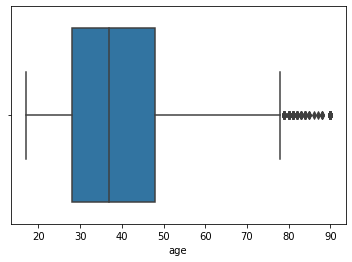

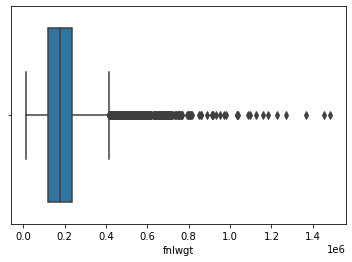

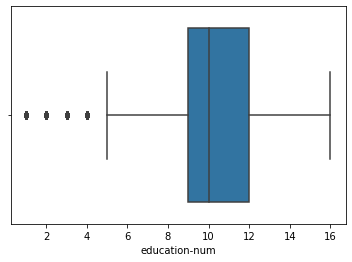

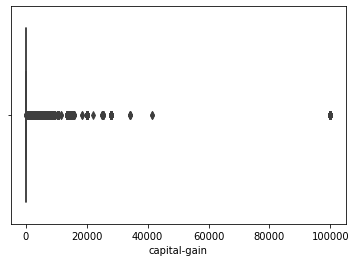

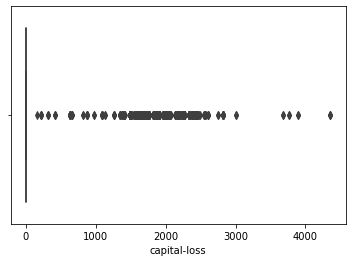

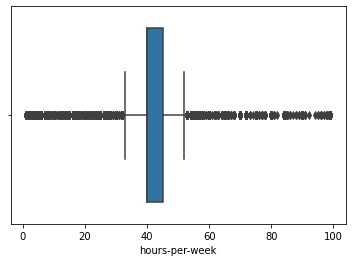

In [12]:
#Look for outliers in numeric data
for column in income._get_numeric_data().columns:
    sns.boxplot(income[column])    
    plt.show()

In [13]:
columns = income.drop(columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'], axis = 1).columns

In [14]:
# Stripping whitespace from beginning of each value
for column in columns:
    income[column] = income[column].apply(lambda x: x.strip())

In [15]:
income['wage'] = np.where(income['wage'] == '>50K', 1, 0)

In [16]:
# Makes a copy of the original dataframe to test whether dropping unknowns altogether is better than renaming them
income_dropna = income.copy()
# Replace ? with NaN
income_dropna.replace(' ?', np.nan, inplace=True)
# Drop all NaN
income_dropna.dropna(inplace=True)
# Categorical columns
columns = income_dropna.drop(columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'wage'], axis = 1).columns
# Stripping whitespace from beginning of each value
for column in columns:
    income_dropna[column] = income_dropna[column].apply(lambda x: x.strip())

In [17]:
income_dropna.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,0


In [18]:
income.head() #columns cleaned and wage binarized

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,0


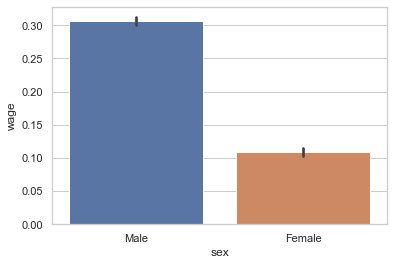

In [19]:
# how much sex impacts in wage
sns.set(style = 'whitegrid')
sns.barplot(x = 'sex', y = 'wage', data = income);

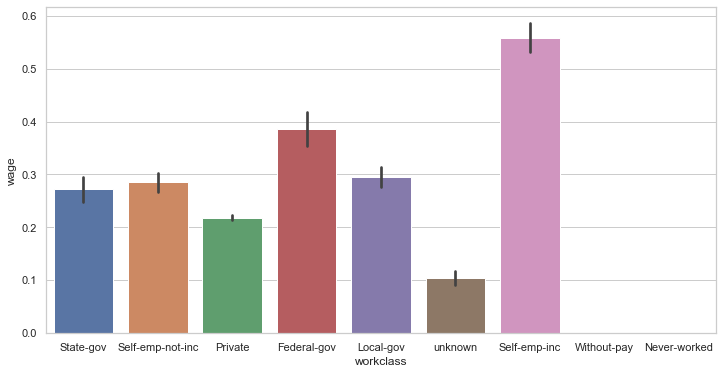

In [20]:
# how much workclass impacts in wage
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')
sns.barplot(x = 'workclass', y = 'wage', data = income);

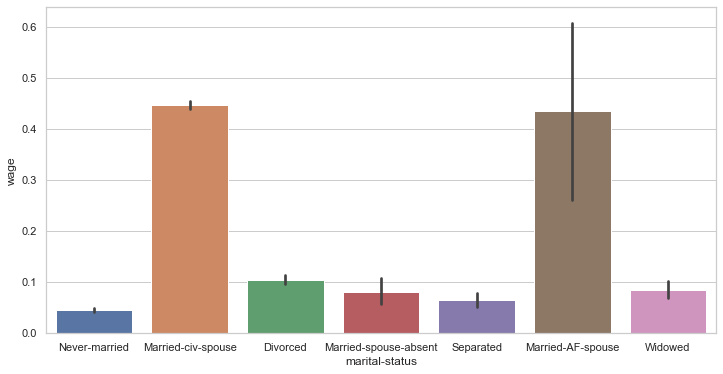

In [21]:
# how much marital status impacts in wage
#percentage of ppl in each class that have above 50k in income 
plt.figure(figsize = (12, 6))
sns.set(style = 'whitegrid')
sns.barplot(x = 'marital-status', y = 'wage', data = income);

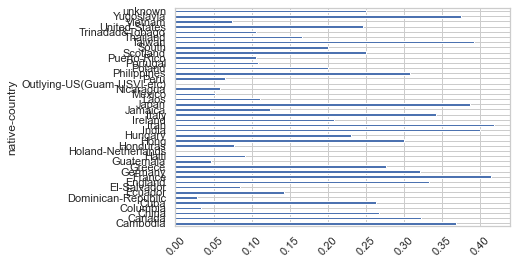

In [22]:
income.groupby('native-country') ['wage'].mean().plot(kind = 'barh')
plt.xticks(rotation=45);

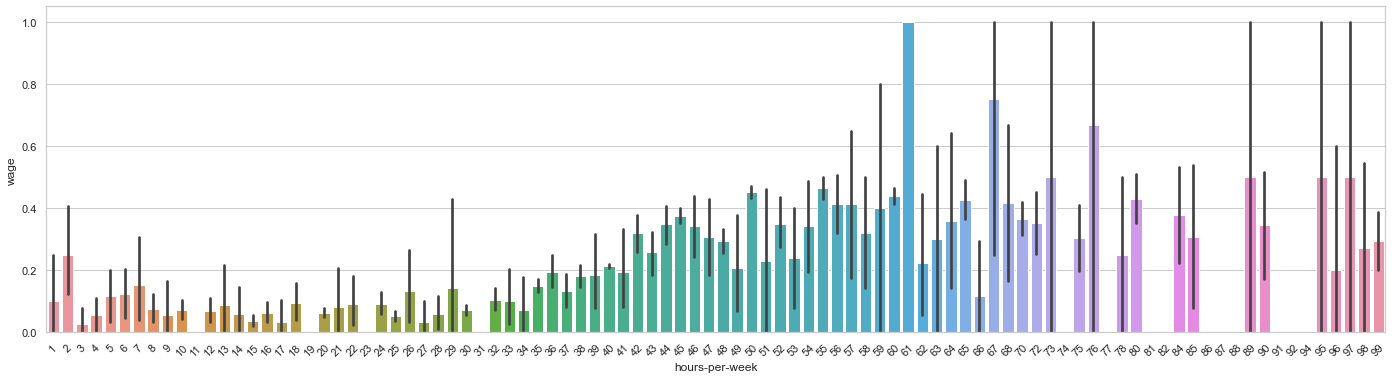

In [23]:
# how much hours impacts wage
plt.figure(figsize = (24, 6))
sns.set(style = 'whitegrid')
sns.barplot(x = 'hours-per-week', y = 'wage', data = income)
plt.xticks(rotation=45);

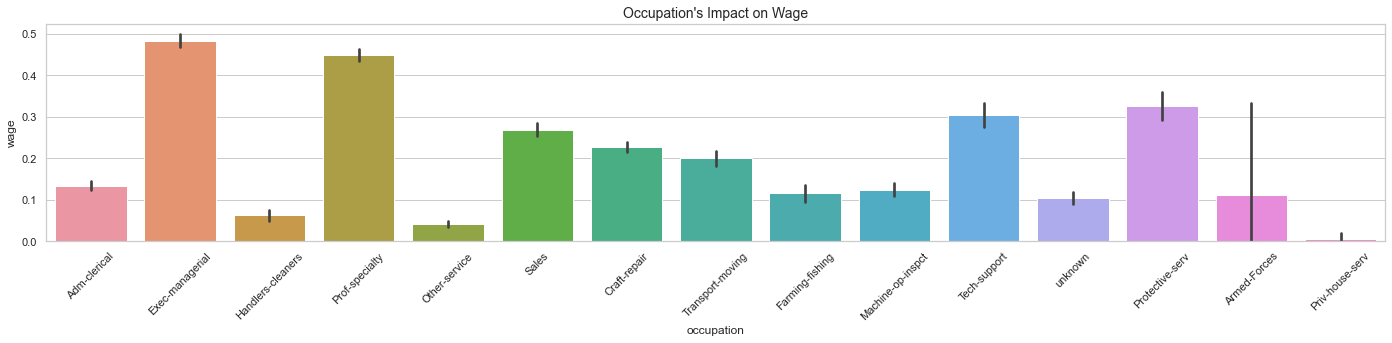

In [24]:
# how much occupation impacts wage
plt.figure(figsize = (24, 4))
sns.set(style = 'whitegrid')
sns.barplot(x = 'occupation', y = 'wage', data = income)
plt.title('Occupation\'s Impact on Wage', size = 14)
plt.xticks(rotation=45);

## Takeaways from EDA:
* Men make more money than women - ~30% of men make more than 50K, ~11% of womeon make more than 50K
* Marital status impacts income drastically - ~45% of people who are married make above 50K
* In the workclass feature, self employed people fare the best. Around ~55% of people in the self-employed workclass make over 50K

In [25]:
X = income(columns = 'age', 'work')

SyntaxError: positional argument follows keyword argument (<ipython-input-25-fe018b7cf3ba>, line 1)

In [26]:
def model_score_classification(X, y, models: list):
    # Split data into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
    # Creating empty df to add to later
    models_df = pd.DataFrame(columns=['model', 
                                      'parameters', 
                                      'train_accuracy',
                                      'train_f1',
                                      'train_spec',
                                      'train_sens',
                                      'test_accuracy',
                                      'test_f1',
                                      'test_spec',
                                      'test_sens'])
    for model in models:
        # Create a pipeline to scale data and pass through model
        pipe = Pipeline([
            ('sc', StandardScaler()),
            ('model', model) # Thanks Lisa Tagliaferri from Digitalocean.com https://www.digitalocean.com/community/tutorials/how-to-use-args-and-kwargs-in-python-3
        ])
        # Fitting the model
        pipe.fit(X_train, y_train)
        # Predictions
        y_train_preds = pipe.predict(X_train)
        y_test_preds = pipe.predict(X_test)
        # Scoring the models
        train_score = pipe.score(X_train, y_train)
        train_f1 = f1_score(y_train, y_train_preds)
        test_score = pipe.score(X_test, y_test)
        test_f1 = f1_score(y_test, y_test_preds)
        # Calculate train specificity and sensitivity
        tn, fn, fp, tp = confusion_matrix(y_train, pipe.predict(X_train)).ravel()
        train_spec = tn / (tn + fp)
        train_sens = tp / (tp + fn)
        # Calculate test specificity and sensitivity
        tn, fn, fp, tp = confusion_matrix(y_test, pipe.predict(X_test)).ravel()
        test_spec = tn / (tn + fp)
        test_sens = tp / (tp + fn)
        # Returning a dictionary of the information
        model_row = {'model' : type(model).__name__, # Thanks Jonathan from Stack Overflow! https://stackoverflow.com/questions/52763325/how-to-obtain-only-the-name-of-a-models-object-in-scikitlearn
                     'parameters' : model.get_params(),
                     'train_accuracy' : train_score,
                     'train_f1' : train_f1,
                     'train_spec' : train_spec,
                     'train_sens' : train_sens,
                     'test_accuracy': test_score,
                     'test_f1': test_f1,
                     'test_spec' : test_spec,
                     'test_sens' : test_sens}
        # Add new row to models_df
        models_df = models_df.append(model_row, ignore_index=True)
    return models_df

In [42]:
classification_models = [LogisticRegression(n_jobs=12),
                        KNeighborsClassifier(n_neighbors=round(np.sqrt(income.shape[0])), n_jobs=12),
                        DecisionTreeClassifier(max_depth=6),
                        BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=6), n_estimators=100, n_jobs=12),
                        RandomForestClassifier(max_depth=6, n_estimators=250, n_jobs=12, random_state=42),
                        AdaBoostClassifier(n_estimators=250, random_state=42),
                        SVC(C=20, random_state=42)]

In [28]:
income.to_csv('./data/train_cleaned.csv', index = False)

In [29]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [30]:
# target encode the following columns
encode_columns = ['workclass', 'education', 'marital-status', 'occupation', 'native-country']
for col in encode_columns:
    encoder = TargetEncoder()
    income[f'{col}_encode'] = encoder.fit_transform(income[col], income['wage'])


/Users/macbookair/opt/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/macbookair/opt/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/macbookair/opt/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/macbookair/opt/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical

In [31]:
features = ['age', 'hours-per-week', 'education-num']
X = income[features]

In [39]:
poly = PolynomialFeatures(include_bias=False, interaction_only = True)

In [33]:
X_poly = poly.fit_transform(X)

In [34]:
poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features))

In [35]:
income_poly = income.join(poly.drop(columns = ['age', 'hours-per-week', 'education-num'], axis = 1), how = 'left')

In [40]:
income_poly.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage,workclass_encode,education_encode,marital-status_encode,occupation_encode,native-country_encode,age^2,age hours-per-week,age education-num,hours-per-week^2,hours-per-week education-num,education-num^2
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,1,2174,0,40,United-States,0,0.271957,0.414753,0.045961,0.134483,0.245835,1521.0,1560.0,507.0,1600.0,520.0,169.0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,1,0,0,13,United-States,0,0.284927,0.414753,0.446848,0.484014,0.245835,2500.0,650.0,650.0,169.0,169.0,169.0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,1,0,0,40,United-States,0,0.218673,0.159509,0.104209,0.062774,0.245835,1444.0,1520.0,342.0,1600.0,360.0,81.0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,1,0,0,40,United-States,0,0.218673,0.051064,0.446848,0.062774,0.245835,2809.0,2120.0,371.0,1600.0,280.0,49.0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,0,0,0,40,Cuba,0,0.218673,0.414753,0.446848,0.449034,0.263158,784.0,1120.0,364.0,1600.0,520.0,169.0


In [37]:
# Binarize the sex column
income_poly['sex'] = np.where(income_poly['sex']=='Male', 1, 0)

In [41]:
income_poly.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage,workclass_encode,education_encode,marital-status_encode,occupation_encode,native-country_encode,age^2,age hours-per-week,age education-num,hours-per-week^2,hours-per-week education-num,education-num^2
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,1,2174,0,40,United-States,0,0.271957,0.414753,0.045961,0.134483,0.245835,1521.0,1560.0,507.0,1600.0,520.0,169.0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,1,0,0,13,United-States,0,0.284927,0.414753,0.446848,0.484014,0.245835,2500.0,650.0,650.0,169.0,169.0,169.0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,1,0,0,40,United-States,0,0.218673,0.159509,0.104209,0.062774,0.245835,1444.0,1520.0,342.0,1600.0,360.0,81.0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,1,0,0,40,United-States,0,0.218673,0.051064,0.446848,0.062774,0.245835,2809.0,2120.0,371.0,1600.0,280.0,49.0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,0,0,0,40,Cuba,0,0.218673,0.414753,0.446848,0.449034,0.263158,784.0,1120.0,364.0,1600.0,520.0,169.0
